# ANALYSIS OF THE BARRO COLORADO ISLAND DATASET

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy.stats import norm
from scipy.stats import binom
from scipy import optimize
import scipy.integrate as integrate

from IPython.display import display, HTML

from numba import jit 
import networkx as nx

#np.random.seed(10)


import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the dataset
origin_data = pd.read_csv('bci05.csv')
data = origin_data[origin_data['status']=='A']
data = data[['sp','gx','gy']]

## NUMBER OF SPECIES

In [3]:
#counting the number of species in the dataset
S = len(data.groupby('sp')) #number of species
print("The number of species in the plot is",S,".")

The number of species in the plot is 299 .


## DATASET PARTITIONING

In [4]:
#dividing the plot in N subplots

plot_length = 1000 #metres
plot_height = 500  #metres
N = 200 #number of subplots
Sub_area = 500*1000/200 #area of each subplot in square meters

#assuming square subplots of side l
l = np.sqrt(Sub_area)
mod_len = int(plot_length//l) #number of subplots that can be fit in the length
mod_hei = int(plot_height//l) #number of subplots that can be fit in the height

#creating a grid of subplots: each subplot is represented by its lower left edge
subplots = np.array([np.array([i*l,j*l]) for i in range(mod_len) for j in range(mod_hei)])
grid_subplots = subplots.reshape(mod_len,mod_hei,2) #this versione of subplots allows for matrix-like management 
                                                    #of the subplots (indexing from lower left angle)

In [5]:
        #############
        # UTILITIES #
        #############

#utility series that holds all species with count 0
specs = data['sp'].unique() #all the different species
completion = pd.Series(np.zeros(len(specs), dtype=int),specs)

#utility function; checks if x is in the interval [y, y+l). Used to group the trees in their respective subplot.
@jit(nopython=True)
def between(x,y,l):
    return np.logical_and(np.less(x,y+l),np.greater_equal(x,y))

In [6]:
        ########################
        # DATASET PARTITIONING #
        ########################

#for each lower left vertex (which denotes a subplot) the different numbers of each species are collected
abundancies = np.array([
    
    data[np.logical_and(between(data['gx'].values,subplots[i,0],l), between(data['gy'].values,subplots[i,1],l))]['sp'].value_counts().sort_index()
    
                for i in range(N)])

    
#the following contains ALL species, even the ones not appearing in the subplot
ab2 = [pd.concat([i,completion])[~pd.concat([i,completion]).index.duplicated(keep='first')].sort_index()
                for i in abundancies]

We imported the dataset and only kept the data which is useful for our analysis, in particular we only considered alive trees among the ones which have been censused and, for each tree, only its species and its position on the two dimensional grid representing the forest. I order to use a maximum entropy model, we need multiple realizations of the same "forest"; to do that, we subdivided the plot in 200 square subplots and assumed they behave exactly like many realizations of a small forest which has the same characteristics of the whole forest. Obviously, this is only true in the limit of an infinite forest, but, under the limitations posed by the quantity of data itslef, this approximation is acceptable. We found out that the number of species in 299, but not all species are present in all of the realizations. In particular, for each subplot we counted the number of individuals for every non-null species in the subplot. Moreover, we call average presence the average of the number of individuals of a certain species on all the subplots.

## MAXIMUM ENTROPY MODEL 1

Using the graph formalism (that is, $G$ denotes one possible graph belonging to the ensemble of graphs $\mathcal{G}$), we can write the entropy and the normalization condition as

$$
S = - \sum_{G \in \mathcal{G}} P(G) \log P(G), \quad \quad \sum_{G \in \mathcal{G}} P(G) = 1.
$$

Given a graph observable, $x_i(G)$, we can set a constraint on it by writing

$$
\sum_{G \in \mathcal{G}} P(G) x_i(G) = \langle x_i(G) \rangle_{emp}, \quad i=1,...,S
$$

where $\langle x_i(G) \rangle_{emp}$ is its empirical value. Maximizing the entropy, together with the constraints (normalization and the additional $S$ ones) with respect to the probability $P(G)$, gives an expression for $P(G)$ itself:

$$
P(G) = \frac{1}{Z} \exp \left(\sum_{i=1}^S \lambda_i x_i(G)\right)
$$

where $\lambda_i$ are the Lagrange multipliers associated with the constraints on the observables and $Z$ is the partition function, defined as

$$
Z = \sum_{G \in \mathcal{G}} \exp \left(\sum_{i=1}^{S} \lambda_i x_i(G)\right)
$$

From $Z$ we can derive analytical expressions for the observables, as

$$
\langle x_i \rangle_{emp} = \frac{\partial}{\partial \lambda_i} \log Z, \quad i=1,...,S
$$

and then, by setting them to be equal to their empirical values, we can obtain the values of the parameters $\lambda$.
Defining the graph hamiltonian as $H(G)=-\sum_{i=1}^{S} \lambda_i x_i(G)$, the partition function can be written as

$$
Z = \sum_{G \in \mathcal{G}} \exp \left(-H(G)\right).
$$

In the first model, the observables are the "magnetizations" 

$$
x_i(G) = 2p_i(G)-1 = \sigma_i(G),\quad \quad i=1,...,S,
$$

so that the constraints are

$$
\sum_{G \in \mathcal{G}} P(G) \sigma_i(G) = \langle \sigma_i \rangle_{emp}, \quad \quad i=1,...,S
$$

where $G$ is to be understood as a possible configuration of magnetizations, and $\sigma_i(G)$ is such that, given a configuration (in our case, a subplot), its value is 1 if the species $i$ is present and -1 otherwise. This results in the following expression for $Z$:

$$
Z = \sum_{\{\sigma\}} \exp \left(- \sum_{i=1}^{S} \lambda_i \sigma_i\right) \rightarrow Z = 2^S \prod_{i=1}^{S}	\cosh (\lambda_i)
$$

Using the graph formalism (that is, $G$ denotes one possible graph belonging to the ensemble of graphs $\mathcal{G}$), we can write the entropy and the normalization condition as

$$
S = - \sum_{G \in \mathcal{G}} P(G) \log P(G), \quad \quad \sum_{G \in \mathcal{G}} P(G) = 1.
$$

Given a graph observable, $x_i(G)$, we can set a constraint on it by writing

$$
\sum_{G \in \mathcal{G}} P(G) x_i(G) = \langle x_i(G) \rangle_{emp}, \quad i=1,...,S
$$

where $\langle x_i(G) \rangle_{emp}$ is its empirical value. Maximizing the entropy, together with the constraints (normalization and the additional $S$ ones) with respect to the probability $P(G)$, gives an expression for $P(G)$ itself:

$$
P(G) = \frac{1}{Z} \exp \left(-\sum_{i=1}^S \lambda_i x_i(G)\right)
$$

where $\lambda_i$ are the Lagrange multipliers associated with the constraints on the observables and $Z$ is the partition function, defined as

$$
Z = \sum_{G \in \mathcal{G}} \exp \left(- \sum_{i=1}^{S} \lambda_i x_i(G)\right)
$$

From $Z$ we can derive analytical expressions for the observables, as

$$
\langle x_i \rangle_{emp} = \frac{\partial}{\partial \lambda_i} \log Z, \quad i=1,...,S
$$

and then, by setting them to be equal to their empirical values, we can obtain the values of the parameters $\lambda$.
Defining the graph hamiltonian as $H(G)=-\sum_{i=1}^{S} \lambda_i x_i(G)$, the partition function can be written as

$$
Z = \sum_{G \in \mathcal{G}} \exp \left(H(G)\right).
$$

In the first model, the observables are the "magnetizations" 

$$
x_i(G) = 2p_i(G)-1 = \sigma_i(G),\quad \quad i=1,...,S,
$$

so that the constraints are

$$
\sum_{G \in \mathcal{G}} P(G) \sigma_i(G) = \langle \sigma_i \rangle_{emp}, \quad \quad i=1,...,S
$$

where $G$ is to be understood as a possible configuration of magnetizations, and $\sigma_i(G)$ is such that, given a configuration (in our case, a subplot), its value is 1 if the species $i$ is present and -1 otherwise. This results in the following expression for $Z$:

$$
Z = \sum_{\{\sigma\}} \exp \left(- \sum_{i=1}^{S} \lambda_i \sigma_i\right) \rightarrow Z = 2^S \prod_{i=1}^{S}	\cosh (\lambda_i)
$$

Then, for $i=1,...S$,

$$
\langle \sigma_i \rangle_{model} = \frac{\partial}{\partial \lambda_i} \log Z \quad
\rightarrow \quad \langle \sigma_i \rangle_{model} = \tanh (\lambda_i)
$$

and imposing the constraints, we get that, for $i=1,...,S$,

$$
\langle \sigma_i \rangle_{emp} = \langle \sigma_i \rangle_{model} \rightarrow \lambda_i = \tanh^{-1}(\langle \sigma_i \rangle_{emp})
$$

The actual values of $\langle \sigma_i \rangle_{emp}$ are calculated as the element-wise average over the $N=200$ subplots, given that, for each subplot, each $\sigma$ is linked to the presence $p_i$ by the relation $\sigma_i=2p_i-1$.
This approach, which is consistent in principle, leads to an (apparent) inconvenience: for species which are always present, their respective $\lambda$s cannot be calculated, as $\tanh^{-1}(1)$ is undefined. As the average presence approaches 1, however, the expected value for its $\lambda$ should approach infinity; this is consistent with the hamiltonian interpretation of the exponent: the probability of a species which is otherwise always present of not appearing becomes 0, as the hamiltonian, when $\sigma_i$=-1, approaches infinity.
On the computational side, this is has been dealt with by setting to 10 the $\lambda$ corresponding to the $\langle \sigma_i \rangle_{emp}$ which are equal to 1.

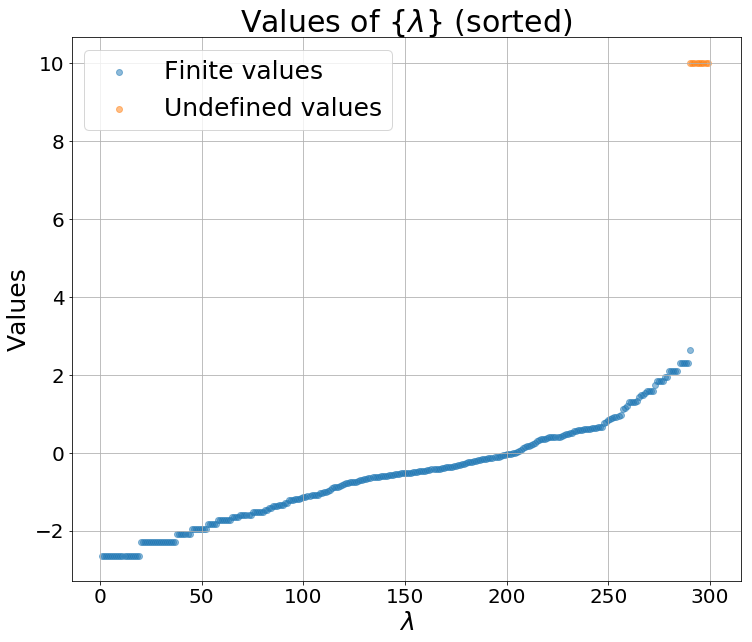

In [7]:
        ################################################
        # CALCULATION AND VISUALIZATION OF THE LAMBDAS #
        ################################################
        
reg = 1e-16 # a small value which, subtracted from the values of the presences, 
            # allows for the computation of the respective lambdas.
    
pres = np.mean(np.array(ab2, dtype = bool), axis=0)
lambdas = np.arctanh((2*pres-1))
lambdas_inf = 10*np.ones(np.isinf(lambdas).sum()) #this array is used just to display the infinites in lambdas
plt.figure(figsize=(12,10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(r"Values of $\{\lambda\}$ (sorted)", fontsize=30)
plt.xlabel(r"$\lambda$", fontsize=25)
plt.ylabel("Values", fontsize=25)
plt.scatter(np.linspace(1,S,S), np.sort(lambdas), alpha = 0.5, label="Finite values")
plt.scatter(np.linspace(S-lambdas_inf.shape[0],S,lambdas_inf.shape[0]), 
            np.sort(lambdas_inf), alpha = 0.5, label="Undefined values")
plt.grid()
plt.legend(fontsize=25)
plt.savefig("lambda.pdf", bbox_inches='tight')
plt.show()

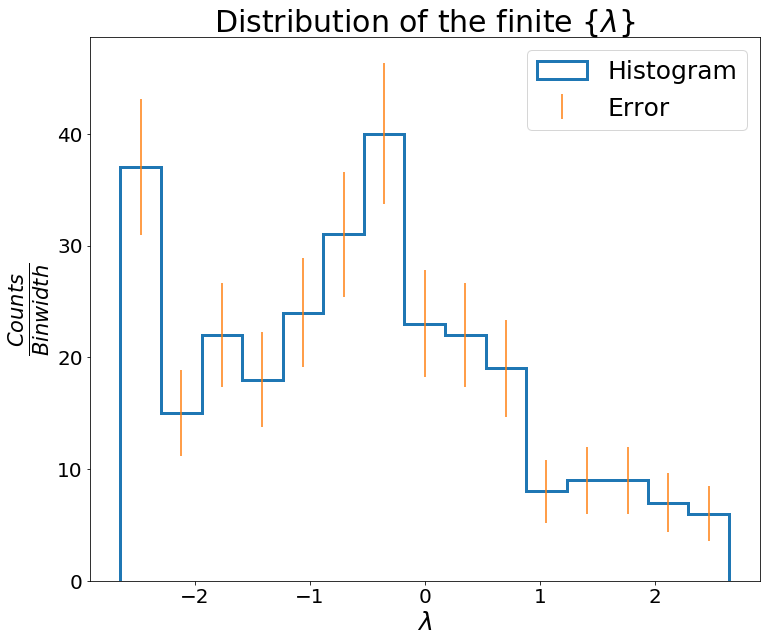

In [8]:
############################
# HISTOGRAM OF THE LAMBDAS #
############################

plt.figure(figsize=(12,10))
plt.title(r"Distribution of the finite $\{\lambda\}$", fontsize=30)
plt.xlabel(r"$\lambda$", fontsize=25)
plt.ylabel(r"$\frac{Counts}{Binwidth}$", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)

bins = 15
y,binEdges = np.histogram(lambdas[np.isfinite(lambdas)],bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)

sns.distplot(lambdas[np.isfinite(lambdas)],bins=bins, rug=False, kde=False, norm_hist=False,
             kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
             hist_kws={"label": "Histogram", "histtype":"step", "alpha": 1, "linewidth": 3})

plt.errorbar(x=bincenters, y=y, yerr=menStd, fmt='none', label="Error")
plt.legend(fontsize=25)
plt.savefig("lambdahist.pdf", bbox_inches='tight')
plt.show()

In [9]:
#measuring the compatibility
comp = np.abs(np.mean(lambdas[np.isfinite(lambdas)])/np.std(lambdas[np.isfinite(lambdas)]))
comp

0.439149070066859

## MAXIMUM ENTROPY MODEL 2

The hamiltonian is now defined as

$$
H(\{\sigma\}; \{\theta\}) = -\sum_{i=1}^{S} \lambda_i \sigma_i - k\frac{\left( \sum_{i=1}^{S} \sigma_i\right)^2}{S}
$$

where $ \{\theta\} $ denotes the family of parameters $\{ \{\lambda_i\}_{i=1}^{S},k\}\}$.

The constraints are 
$$
2p_i-1 = \langle \sigma_i \rangle_{emp} = \langle \sigma_i \rangle_{model}
$$

$$
\frac{\langle \left(S_+-S_-\right)^2 \rangle_{emp}}{S} = \frac{\langle \left(\sum_{i=1}^{S} \sigma_i \right)^2 \rangle_{emp}}{S}
$$

This choice (joining the $S$ to the sum of the presences in the last constraint) allows for better numerical convergence.

The numerical solution follows.

In [10]:
        #########################
        # EMPIRICAL CONSTRAINTS #
        #########################


# constraint for k ----> sig_sq
# constraints for the lambdas ----> pres

sig_sq = np.mean(np.square(np.sum(2*np.array(ab2, dtype=bool)-1, axis=1)))/S
sigma = np.mean(2*np.array(ab2, dtype=bool)-1, axis=0)

Here we define the needed algorithms (metropolis, ADAM gradient descent).

In [11]:
#########################
# NUMERICAL SIMULATIONS #
#########################



beta = 1 #not actually needed...
S = 299
sims = int(1e5)

############################
# calculating the energies #
############################

@jit(nopython=True)
def hamilt(config, param):
    pr = np.sum(np.array([config[i]*param[i] for i in range(len(config))]))
    #k=param[-1]!
    return -pr-(param[-1]/S)*(np.square(np.sum(config)))


########################################################
# producing N states generated by metropolis algorithm #
########################################################
@jit(nopython=True)
def metropolis(param, sims=1e4, N=1000, S=299):
    
    state = np.random.choice(np.array([+1,-1]), size=S)
    metr_state = [state]
  
    for i in range(sims):
        
        new_state = np.array([i for i in state])
        new_state[np.random.randint(S)] *= (-1)
        
        if hamilt(new_state, param)<hamilt(state, param):
            state = new_state    #changing state wp 1
        else:
            if np.random.uniform(0,1)<np.exp(-beta*(hamilt(new_state, param)-hamilt(state, param))):
                state = new_state     # changing state wp exp(-b(delta_E))
                
        metr_state.append(state)
        
    return metr_state[sims-N:] #returns the last N states (hopefully stable!)


############################################################
# implementing ADAM in order to achieve better convergence #
############################################################
def ADAM(param, m, s, metro_state, t, emp = np.append(sigma,sig_sq),
         beta1 = 0.9, beta2 = 0.99, eps = 1e-8, l_rate = 0.0001):
    
    metro_avg = np.mean(metro_state, axis=0) #averages calculated from the simulated states
    metro_sig_sq = np.mean(np.square(np.sum(metro_state, axis=1)))/S #constraint on k calculated on the simulated states
    g = -(emp - np.append(metro_avg, metro_sig_sq))
    m = ((beta1*m)+(1-beta1)*g)
    s = ((beta2*s)+(1-beta2)*(g**2))
    
    return param - l_rate * ( (m/(1-beta1**t))  /  ((s/(1-beta2**t))**.5+eps) ), m, s


##########################
# adjourning the lambdas #
##########################
def adjourn(param, emp_avg, sig_sq, metr_st, learn_rate=1):
    metr = np.array(metr_st)
    #averages calculated from the simulated states
    metr_avg = np.mean(metr, axis=0)
    #constraint on k calculated on the simulated states
    metr_sig_sq = np.mean(np.square(np.sum(metr, axis=1)))/S
    
    lamb = [param[i]+learn_rate*(emp_avg[i]-metr_avg[i]) for i in range(S)]
    k = param[-1]+learn_rate*(sig_sq-metr_sig_sq)

    return np.append(np.array(lamb),k)

We first tried to estimate the parameters by intializating them as normal distributed values with $\mu=0$ and  $\sigma=1$, for both the standard gradient descent (SGD) and ADAM.

In [12]:
################################
# initialization of the params #
################################

k = np.random.normal()
param = np.append(np.random.normal(0,1, size=S),k)
param_ADAM = np.copy(param)

In [13]:
###################################### SGD ######################################

####################
# algorithm params #
####################

epochs = 5000 #number of adjournments
N = 200 #number of metropolis states over which we calculate the average
sims = 2e4 #number of steps in metropolis algorithms
learn_rate = 0.002


##########################
# calculating the params #
##########################

param_history = [param]
for i in range(epochs):
    param = adjourn(param, sigma, sig_sq, metropolis(param, sims, N), learn_rate=learn_rate)
    param_history.append(param)
    
#the resulting parameters are computed as the mean of their values over the last "his" iterations

his = 100 #the amount of iterations over which to average
param = np.mean(param_history[epochs-his:], axis=0)    

In [14]:
###################################### ADAM ######################################

####################
# algorithm params #
####################

epochs = 5000  #number of adjournments
N = 200       #number of metropolis states over which we calculate the average
sims = 2e4    #number of steps in metropolis algorithms
learn_rate = 0.002


##########################
# calculating the params #
##########################

param_history_ADAM = [param_ADAM]
m,s = np.zeros(S+1),np.zeros(S+1) #initializing the moments parameters
for i in range(epochs):
    param_ADAM, m, s = ADAM(param_ADAM, m, s, metropolis(param_ADAM, sims, N), i+1, l_rate=learn_rate)
    param_history_ADAM.append(param_ADAM)
    
#the resulting parameters are computed as the mean of their values over the last "his" iterations

his = 100 #the amount of iterations over which to average the parameters
param_ADAM = np.mean(param_history_ADAM[epochs-his:], axis=0) 

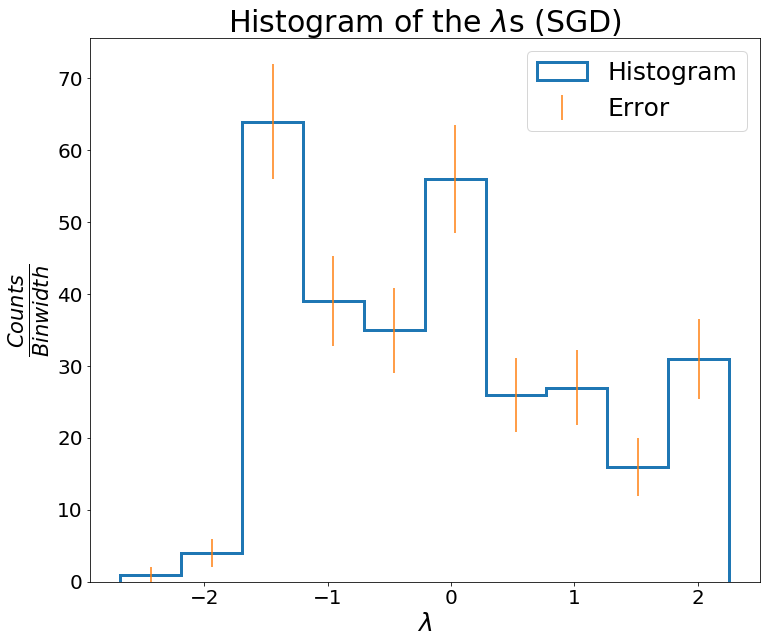

In [15]:
################################
# HISTOGRAM OF THE SGD LAMBDAS #
################################

plt.figure(figsize=(12,10))
plt.title(r"Histogram of the $\lambda$s (SGD)", fontsize=30)
plt.xlabel(r"$\lambda$", fontsize=25)
plt.ylabel(r"$\frac{Counts}{Binwidth}$", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)

bins = 10
y,binEdges = np.histogram(param[:-1],bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)

sns.distplot(param[:-1],bins=bins, rug=False, kde=False, norm_hist=False,
             kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
             hist_kws={"label": "Histogram", "histtype":"step", "alpha": 1, "linewidth": 3})
plt.errorbar(x=bincenters, y=y, yerr=menStd, fmt='none', label="Error")

plt.legend(fontsize=25)
plt.savefig("lambdahistsgd.pdf", bbox_inches='tight')
plt.show()

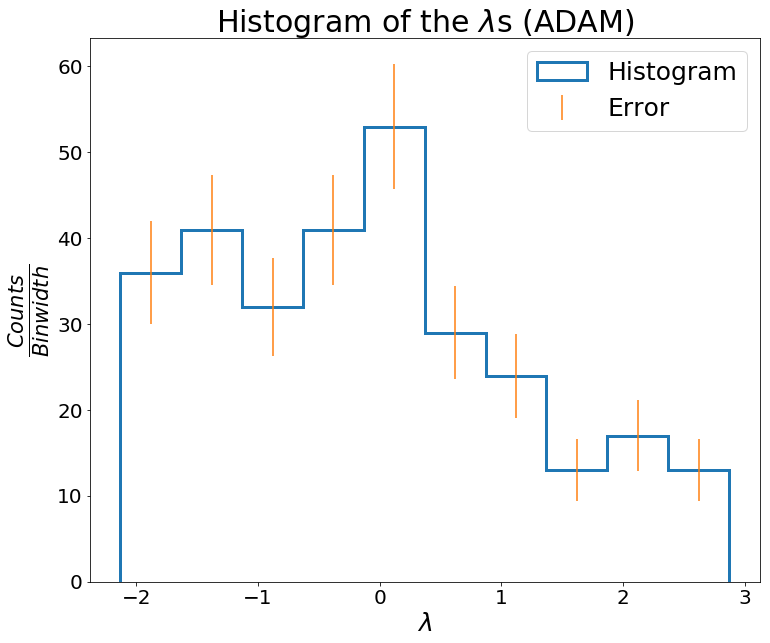

In [16]:
#################################
# HISTOGRAM OF THE ADAM LAMBDAS #
#################################

plt.figure(figsize=(12,10))
plt.title(r"Histogram of the $\lambda$s (ADAM)", fontsize=30)
plt.xlabel(r"$\lambda$", fontsize=25)
plt.ylabel(r"$\frac{Counts}{Binwidth}$", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)

bins = 10
y,binEdges = np.histogram(param_ADAM[:-1],bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)

sns.distplot(param_ADAM[:-1],bins=bins, rug=False, kde=False, norm_hist=False,
             kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
             hist_kws={"label": "Histogram", "histtype":"step", "alpha": 1, "linewidth": 3})
plt.errorbar(x=bincenters, y=y, yerr=menStd, fmt='none', label="Error")

plt.legend(fontsize=25)
plt.savefig("lambdahistsgd.pdf", bbox_inches='tight')
plt.show()

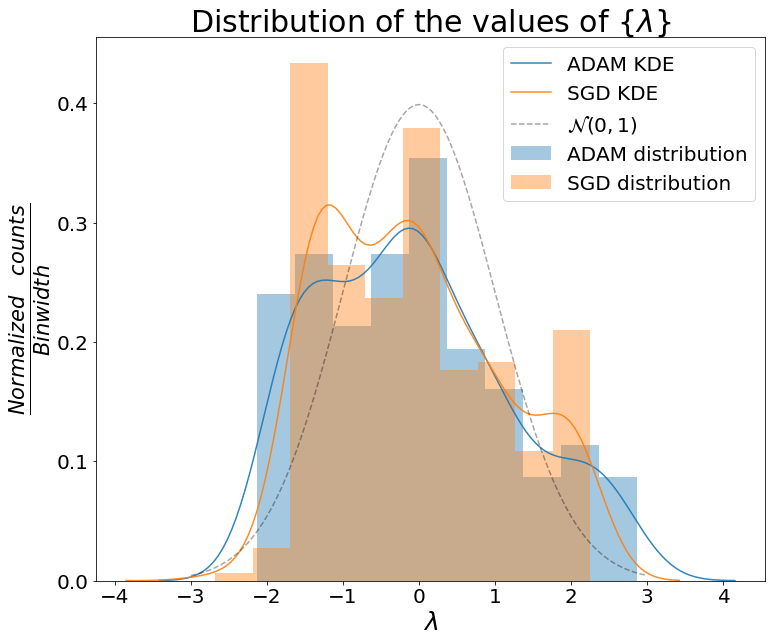

In [17]:
#################################
# HISTOGRAM OF BOTH THE LAMBDAS #
#################################

plt.figure(figsize=(12,10))
plt.title(r"Distribution of the values of $\{\lambda\}$", fontsize=30)
plt.xlabel(r"$\lambda$", fontsize=25)
plt.ylabel(r"$\frac{Normalized\quadcounts}{Binwidth}$", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)

bins = 10

sns.distplot(param_ADAM[:-1],bins=bins, rug=False, kde=True, norm_hist=False,
             kde_kws={"label": "ADAM KDE", "alpha": 0.9},
             hist_kws={"label": "ADAM distribution"})

sns.distplot(param[:-1],bins=bins, rug=False, kde=True, norm_hist=False,
             kde_kws={"label": "SGD KDE", "alpha": 0.9},
             hist_kws={"label": "SGD distribution"})

x_axis = np.arange(-3, 3, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,1), label = r"$\mathcal{N}(0,1)$", 
        color='k', alpha=0.35, linestyle='--')

plt.legend(fontsize=20)
plt.savefig("lambdahistboth.pdf", bbox_inches='tight')
plt.show()

## RANDOM FIELD MODEL

In [18]:
# checking compatibility of the average of the lambdas with 0

comp = np.abs(np.mean(param[:-1])/np.std(param[:-1])) #k must not be taken into account
print(r"The GD compatibility of the lambdas with 0 is:", comp)

compADAM = np.abs(np.mean(param_ADAM[:-1])/np.std(param_ADAM[:-1]))
print(r"The ADAM compatibility of the lambdas with 0 is:", compADAM)

The GD compatibility of the lambdas with 0 is: 0.06683112348787915
The ADAM compatibility of the lambdas with 0 is: 0.055178530089924065


The SGD solutions are less compatible with 0 than their ADAM counterparts.

We now try to quickly compare the distribution of the $\{\lambda\}$ with a gaussian with mean and std equal to those of the parameters themselves.

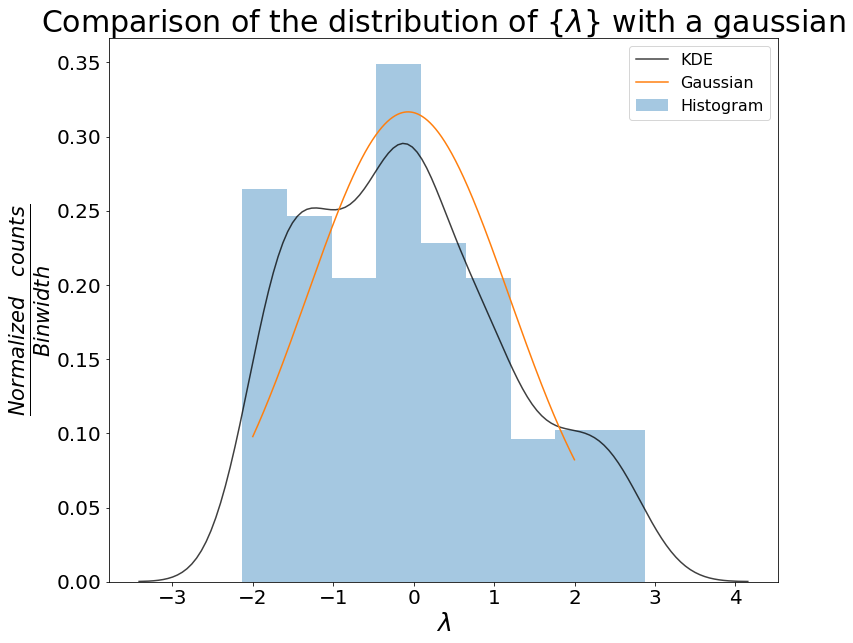

In [19]:
plt.figure(figsize=(12,10))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title(r"Comparison of the distribution of $\{\lambda\}$ with a gaussian", fontsize=30)
plt.xlabel(r"$\lambda$", fontsize=25)
plt.ylabel(r"$\frac{Normalized\quadcounts}{Binwidth}$", fontsize=30)
sns.distplot(param_ADAM[:-1], rug=False, 
             kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
             hist_kws={"label": "Histogram"})
x_axis = np.arange(-2, 2, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,np.mean(param_ADAM[:-1]),np.std(param_ADAM[:-1])), label = "Gaussian")
plt.legend(fontsize=16)
plt.show()

It is clear, just by looking at the KDE vs. the respective gaussian, that the assumption of gaussian distributed $\{\lambda\}$ is not particularly accurate, as the distribution is bimodal. However, the comparison will be carried out despite this small inconvenience. The lagrange multipliers will be used as the random fields, despite their non-gaussian distribution.

The RFIM hamiltonian for $N$ connected spins with interaction strength $J$ is:
$$
H(\{\sigma\}) = - \sum_{i=1}^N \lambda_i \sigma_i - \frac{J}{N} \sum_{i,j}\sigma_i \sigma_j
$$

However, the results pertaining to the phase diagram of the RFIM can be adapted to our situation. In particular:

* $\sigma$, which was to be intended as the variance of the random fields, is substituted by the variance of the Lagrange multipliers: 

$$ \sigma = \sqrt{\text{var}(\{\lambda\})} $$
* the coupling constant $J$ is substituted by the value of $k$;
* the number of spins $N$ is substituted by the number of species $S$.

The RFIM has a phase transition curve which follows the following integral curve:

$$
2J(\sigma) = \int_{-\infty}^{+\infty} \frac{\text{d}x}{\sqrt{2 \pi \sigma^2}} \left(  
\frac{\exp \left( {-\frac{x^2}{2 \sigma^2}} \right)}{\left( \cosh x \right)^2} \right)
$$
 
The hamiltonian of the model at hand is then represented by the point $\left(\frac{\sum_{i=1}^{S} \lambda_i}{S} ; k\right)$. Its eventual proximity to the phase transition curve will then be a rough estimate of our system's proximity to criticality. However, once again, the parameters shifted from a normal distribution towards a roughly bimodal one, so any comparison with RFIM should be at least cautious.

In [20]:
##########################
# PHASE TRANSITION CURVE #
##########################

def phase(sig):
    func = lambda x:(1/(np.sqrt(2*np.pi*np.square(sig))))*((np.exp(-0.5*np.square(x/sig)))/(np.square(np.cosh(x))))
    integr,_ = integrate.quad(func, -np.inf, np.inf)
    res = 1/(2*integr)
    return res

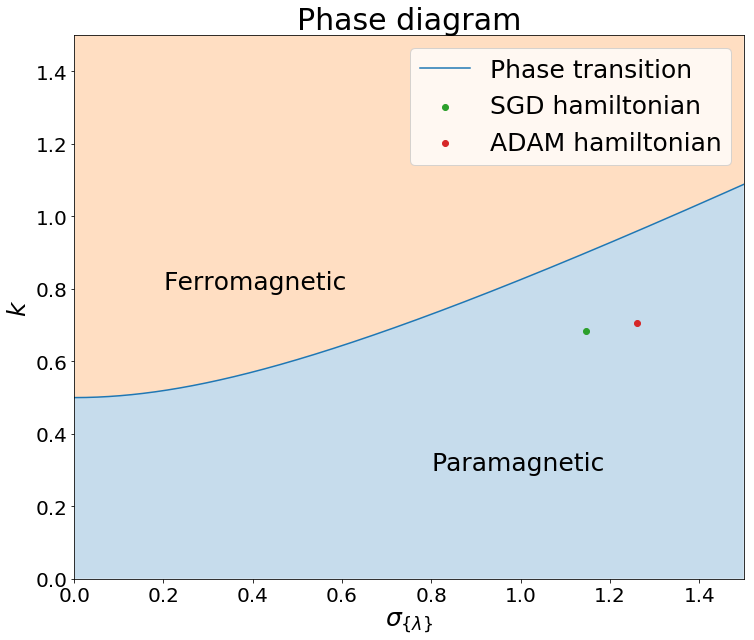

In [21]:
#########################
# PHASE TRANSITION PLOT #
#########################


plt.figure(figsize=(12,10))
plt.title("Phase diagram", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
xs = np.linspace(0.001,1.5,1000)
points = np.array([phase(i) for i in xs])
plt.xlabel(r"$\sigma_{\{\lambda\}}$", fontsize=25)
plt.ylabel(r"$k$", fontsize=25)
plt.plot(xs, points, label = "Phase transition")
plt.text(0.2, 0.8, "Ferromagnetic", fontsize=25)
plt.text(0.8, 0.3, "Paramagnetic", fontsize=25)
plt.fill_between(xs, 0, points, alpha=0.25)
plt.fill_between(xs, points, 1.5, alpha=0.25)
plt.scatter(np.std(param[:-1]), param[-1], label = "SGD hamiltonian")
plt.scatter(np.std(param_ADAM[:-1]), param_ADAM[-1], label = "ADAM hamiltonian")
plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.legend(fontsize=25)
plt.savefig("phase_diagram.pdf", bbox_inches='tight')
plt.show()

The resulting points are relatively close to the transition line. As a lot of information has been lost in treating species as $\pm1$ despite their abundance. The results are to be taken with caution. However, they seem to hint towards the theory according to which biological systems are poised at criticality.

Using a Ising like interpretation:

* the paramagnetic phase would be characterized by completely random configurations. In the BIC dataset, this would correspond to completely unrelated presences.
* the ferromagnetic phase, on the other hand, would be characterized by the substantial homogeneity of the dataset.

None of the two seem to capture the features of the actual dataset: by plotting the most abundant species, some form of clustering is apparent. Some species are now plotted, together with the subplot subdivisions, in order to show this.

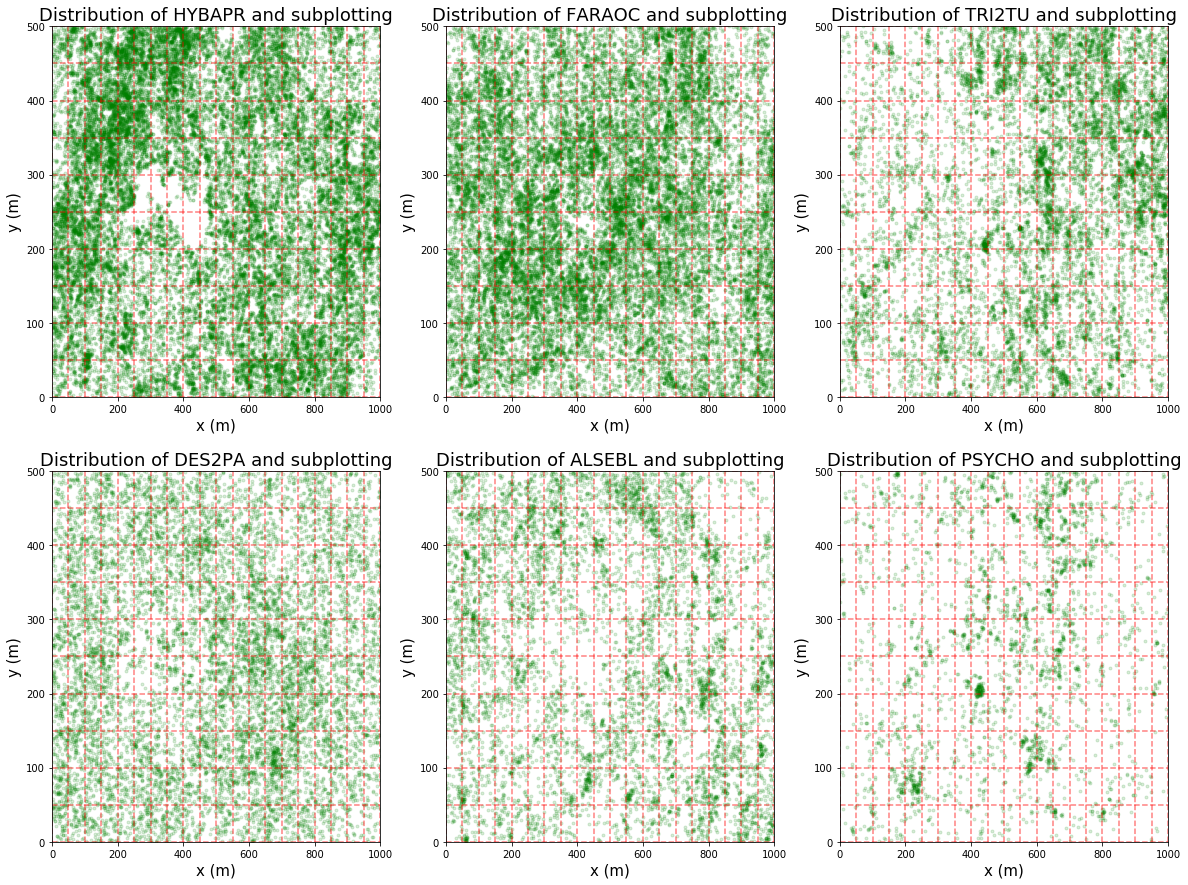

In [22]:
        ##########################################
        # VISUALIZATION OF THE TREE DISTRIBUTION #
        ##########################################


xs=np.linspace(0,S,S) 

gridsize = (2,3)
figure = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid(gridsize, (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(gridsize, (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid(gridsize, (0,2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid(gridsize, (1,0), rowspan=1, colspan=1)
ax5 = plt.subplot2grid(gridsize, (1,1), rowspan=1, colspan=1)
ax6 = plt.subplot2grid(gridsize, (1,2), rowspan=1, colspan=1)

ax1.set_title("Distribution of HYBAPR and subplotting", fontsize=18)
ax1.set_xlabel("x (m)", fontsize=15)
ax1.set_ylabel("y (m)", fontsize=15)
ax1.scatter(data['gx'][data['sp']=="HYBAPR"],data['gy'][data['sp']=="HYBAPR"], color='green', alpha=0.15, marker='.')
ax1.vlines(np.array([i*l for i in range(mod_len+1)]), ymin=0, ymax=500, color='red', linestyle='--', alpha=0.5)
ax1.hlines(np.array([i*l for i in range(mod_hei+1)]), xmin=0, xmax=1000, color='red', linestyle='--', alpha=0.5)
ax1.set_xlim(0,plot_length)
ax1.set_ylim(0,plot_height)

ax2.set_title("Distribution of FARAOC and subplotting", fontsize=18)
ax2.set_xlabel("x (m)", fontsize=15)
ax2.set_ylabel("y (m)", fontsize=15)
ax2.scatter(data['gx'][data['sp']=="FARAOC"],data['gy'][data['sp']=="FARAOC"], color='green', alpha=0.15, marker='.')
ax2.vlines(np.array([i*l for i in range(mod_len+1)]), ymin=0, ymax=500, color='red', linestyle='--', alpha=0.5)
ax2.hlines(np.array([i*l for i in range(mod_hei+1)]), xmin=0, xmax=1000, color='red', linestyle='--', alpha=0.5)
ax2.set_xlim(0,plot_length)
ax2.set_ylim(0,plot_height)

ax3.set_title("Distribution of TRI2TU and subplotting", fontsize=18)
ax3.set_xlabel("x (m)", fontsize=15)
ax3.set_ylabel("y (m)", fontsize=15)
ax3.scatter(data['gx'][data['sp']=="TRI2TU"],data['gy'][data['sp']=="TRI2TU"], color='green', alpha=0.15, marker='.')
ax3.vlines(np.array([i*l for i in range(mod_len+1)]), ymin=0, ymax=500, color='red', linestyle='--', alpha=0.5)
ax3.hlines(np.array([i*l for i in range(mod_hei+1)]), xmin=0, xmax=1000, color='red', linestyle='--', alpha=0.5)
ax3.set_xlim(0,plot_length)
ax3.set_ylim(0,plot_height)


ax4.set_title("Distribution of DES2PA and subplotting", fontsize=18)
ax4.set_xlabel("x (m)", fontsize=15)
ax4.set_ylabel("y (m)", fontsize=15)
ax4.scatter(data['gx'][data['sp']=="DES2PA"],data['gy'][data['sp']=="DES2PA"], color='green', alpha=0.15, marker='.')
ax4.vlines(np.array([i*l for i in range(mod_len+1)]), ymin=0, ymax=500, color='red', linestyle='--', alpha=0.5)
ax4.hlines(np.array([i*l for i in range(mod_hei+1)]), xmin=0, xmax=1000, color='red', linestyle='--', alpha=0.5)
ax4.set_xlim(0,plot_length)
ax4.set_ylim(0,plot_height)

ax5.set_title("Distribution of ALSEBL and subplotting", fontsize=18)
ax5.set_xlabel("x (m)", fontsize=15)
ax5.set_ylabel("y (m)", fontsize=15)
ax5.scatter(data['gx'][data['sp']=="ALSEBL"],data['gy'][data['sp']=="ALSEBL"], color='green', alpha=0.15, marker='.')
ax5.vlines(np.array([i*l for i in range(mod_len+1)]), ymin=0, ymax=500, color='red', linestyle='--', alpha=0.5)
ax5.hlines(np.array([i*l for i in range(mod_hei+1)]), xmin=0, xmax=1000, color='red', linestyle='--', alpha=0.5)
ax5.set_xlim(0,plot_length)
ax5.set_ylim(0,plot_height)

ax6.set_title("Distribution of PSYCHO and subplotting", fontsize=18)
ax6.set_xlabel("x (m)", fontsize=15)
ax6.set_ylabel("y (m)", fontsize=15)
ax6.scatter(data['gx'][data['sp']=="PSYCHO"],data['gy'][data['sp']=="PSYCHO"], color='green', alpha=0.15, marker='.')
ax6.vlines(np.array([i*l for i in range(mod_len+1)]), ymin=0, ymax=500, color='red', linestyle='--', alpha=0.5)
ax6.hlines(np.array([i*l for i in range(mod_hei+1)]), xmin=0, xmax=1000, color='red', linestyle='--', alpha=0.5)
ax6.set_xlim(0,plot_length)
ax6.set_ylim(0,plot_height)


plt.show()


As these graphs suggest, the actual distribution of the trees shows some measure of clustering. As such, the proximity to the transition line seems justified.

## MAXIMUM ENTROPY MODEL 3

The Max Ent 3 model takes into account information about the abundances. The constraints are

\begin{align}
\langle x_i\rangle_{emp} = \langle x_i\rangle_{model}, \quad \langle x_ix_j\rangle_{emp} = \langle x_ix_j\rangle_{model}
\end{align}

meaning that, in addition to the abundances, we are also considering the two point correlation functions; these are symmetric, so the same is expected for the corresponding multipliers.
The hamiltonian reads

\begin{align*}
H(\{\vec{x}\}) &= - \sum_{i=1}^S \lambda^{(g)}_i x_i - \frac{1}{2}\sum_{i,j}^S \lambda^{(g)}_{ij}x_jx_i\label{hamilton_maxent3} \\
&\text{where}\quad\lambda_{ij}^{(g)} = \lambda_{ji}^{(g)}
\end{align*}

The calculation of the partition function $Z$ can then proceed by means of a gaussian integral, provided that the related approximation (for each species, an integral over the real half-line gets substituted by an integration over the whole real line, despite the abundances being positive values) is not too dramatic.

The following condition is then imposed, so that only species with a "mostly to the right" gaussian are kept:

$$
\langle x_i \rangle_{emp} > \sigma_{x,i}
$$

where $ \sigma_{x,i}$ is the standard deviation of the $i$-th species averaged over the $N$ subplots.

In [23]:
# keeping only those species which satisfy the condition <x_i>_emp -thresh*sigma_x,i>0
thresh = 1

emp_avg = np.mean(np.array(ab2), axis=0)
emp_var = np.sqrt(np.var(np.array(ab2), axis=0))
mask = emp_avg-thresh*emp_var>0

# inverse of the covariance matrix
M = np.linalg.inv(np.cov((np.array(ab2).T)[mask]))

lambdas_g = M.dot(emp_avg[mask])

The matrix $\mathbf{M}$ can be thought of as the interaction matrix between species. We now set its diagonal to 0, as to ignore any eventual self-interactoin term.

In [24]:
#cleaning the diagonal, setting it to 0: no self interactions
np.fill_diagonal(M,0)

We are now ready to employ the results concerning the gaussian approximation in order to estimate the values of the parameters. These results read as follows:

\begin{align}
\vec{\lambda}^{(g)} = \mathbf{M}\langle\vec{x}\rangle_{emp}, \quad \mathbf{M}^{-1}_{ij}=\text{Cov}(x_i,x_j) \quad i,j=1,...,S'
\end{align}

The distribution of both $\{\lambda^{(g)}\}$ and $\mathbf{M}$ is plotted.

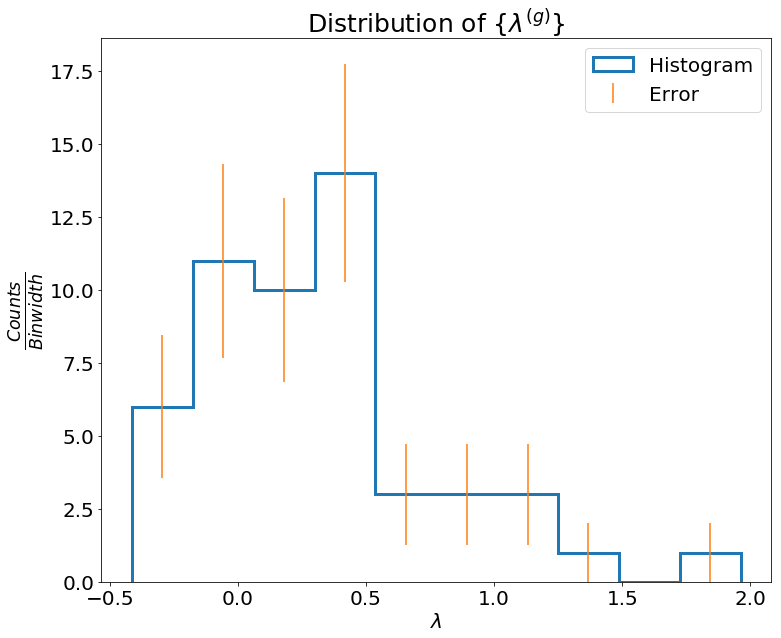

In [25]:
#plotting the histograms of the lambdas and the elements of the covariance matrix
plt.figure(figsize=(12,10))
plt.title(r"Distribution of $\{\lambda^{(g)}\}$", fontsize=25)
plt.ylabel(r"$\frac{Counts}{Binwidth}$", fontsize=25)
plt.xlabel(r"$\lambda$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

bins = 10
y,binEdges = np.histogram(lambdas_g,bins=bins,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)

sns.distplot(lambdas_g, bins=bins, rug=False, kde=False, norm_hist=False,
             kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
             hist_kws={"label": "Histogram", "histtype":"step", "alpha": 1, "linewidth": 3})

plt.errorbar(x=bincenters, y=y, yerr=menStd, fmt='none', label="Error")

plt.legend(fontsize=20)
plt.savefig("hist1.pdf", bbox_inches='tight')
plt.show()

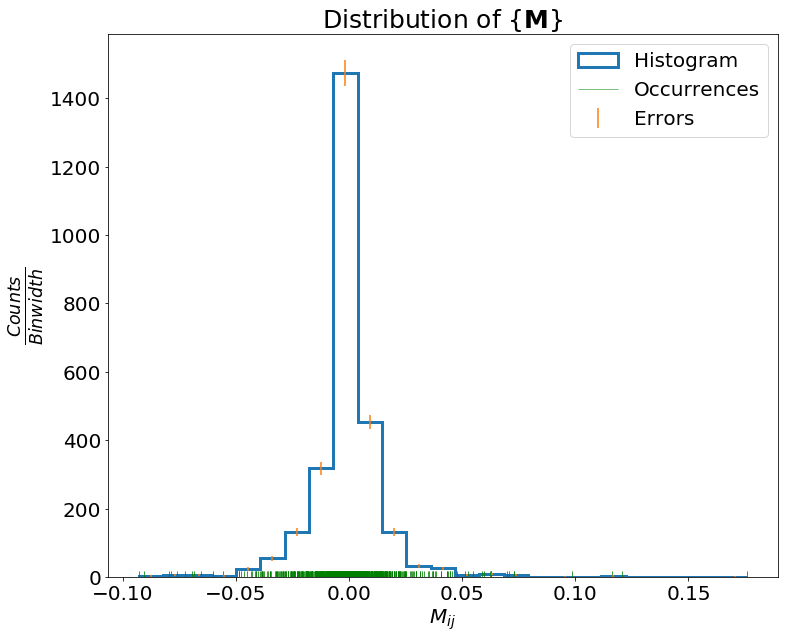

In [26]:
plt.figure(figsize=(12,10))
plt.title(r"Distribution of $\{\mathbf{M}\}$", fontsize=25)
plt.ylabel(r"$\frac{Counts}{Binwidth}$", fontsize=25)
plt.xlabel(r"$M_{ij}$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

bins = 25
y,binEdges = np.histogram(M.flatten(),bins=bins,density=False)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
menStd     = np.sqrt(y)

sns.distplot(M.flatten(), bins=bins, rug=True, kde=False, norm_hist=False,
             kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
             hist_kws={"label": "Histogram", "histtype":"step", "alpha":1, "linewidth": 3},
             rug_kws={"label": "Occurrences", "alpha": 0.5, "height":0.0125, "color":"green"})

plt.errorbar(x=bincenters, y=y, yerr=menStd, fmt='none', label="Errors", barsabove=True)

plt.legend(fontsize=20)
plt.savefig("hist2.pdf", bbox_inches='tight')
plt.show()

## NETWORK ANALYSIS

The matrix $\mathbf{M}$ can be thought of as the weighted adjacency matrix of the graph of the species interactions.

We can set a threshold $\theta>0$, and then set the elements of $\mathbf{M}$ to 0 if their absolute value is smaller than $\theta$. This procedure allows for the trimming if the least significant interactions. We can then take the value $\theta^\star$, defined as the highest value of $\theta$ for which the interaction graph is still made of a single connected component. This graph, named $W^\star$, will then be analyzed in its structural properties.

In [27]:
#number of connected components using the laplacian matrix
def count_components(A, tol=0):
    deg = np.diag(np.sum(A.astype(bool),axis=1)) #the degree matrix 
    laplacian = deg - A #computes the laplacian matrix
    return np.sum(np.abs(np.linalg.eigvals(laplacian))<=tol)

In [28]:
# trimming

theta = np.linspace(0, M.max(), 10000)
Matrices = np.array([(np.absolute(M.copy())>i)*M.copy() for i in theta])
index = np.sum(np.array([count_components(i) for i in Matrices])<1)-1
theta_star = theta[index]
print("The threshold value is "+'%.4f' % theta_star)

The threshold value is 0.0031


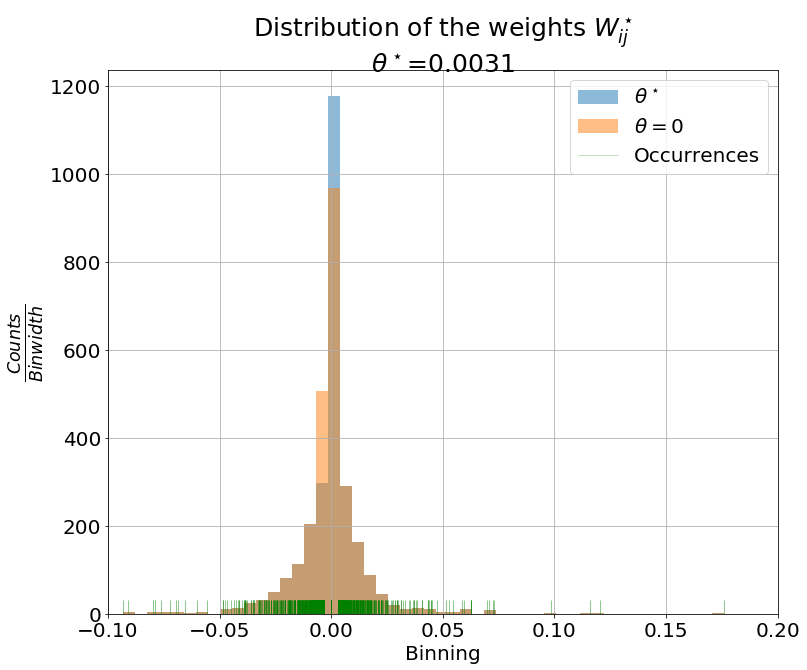

In [29]:
plt.figure(figsize=(12,10))
plt.tick_params(axis='both', which='major', labelsize=20)

sns.distplot(Matrices[index].flatten(), bins=50, rug = True, kde=False, 
             rug_kws={"color": "g", "alpha": 0.25, "height":0.025, "label":"Occurrences"},
            kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
            hist_kws={"label": "Histogram", 
                        "alpha":0.5, "linewidth": 3,"label": r"$\theta^\star$"})

sns.distplot(Matrices[0].flatten(), bins=50, rug = False, kde=False, 
             rug_kws={"color": "g", "alpha": 0.15, "height":0.025},
            kde_kws={"color": "k", "label": "KDE", "alpha": 0.75},
            hist_kws={"label": "Histogram",
                        "alpha":0.5, "linewidth": 3,"label": r"$\theta=0$"})

plt.title(r"Distribution of the weights $W^\star_{ij}$"+ '\n' +r"$\theta^\star$="+'%.4f' % theta_star, fontsize=25)
plt.xlabel("Binning", fontsize=20)
plt.xlim(-.1, .2)
plt.ylabel(r"$\frac{Counts}{Binwidth}$", fontsize=25)
plt.grid()
plt.legend(fontsize=20)
plt.savefig("trimming.pdf", bbox_inches='tight')

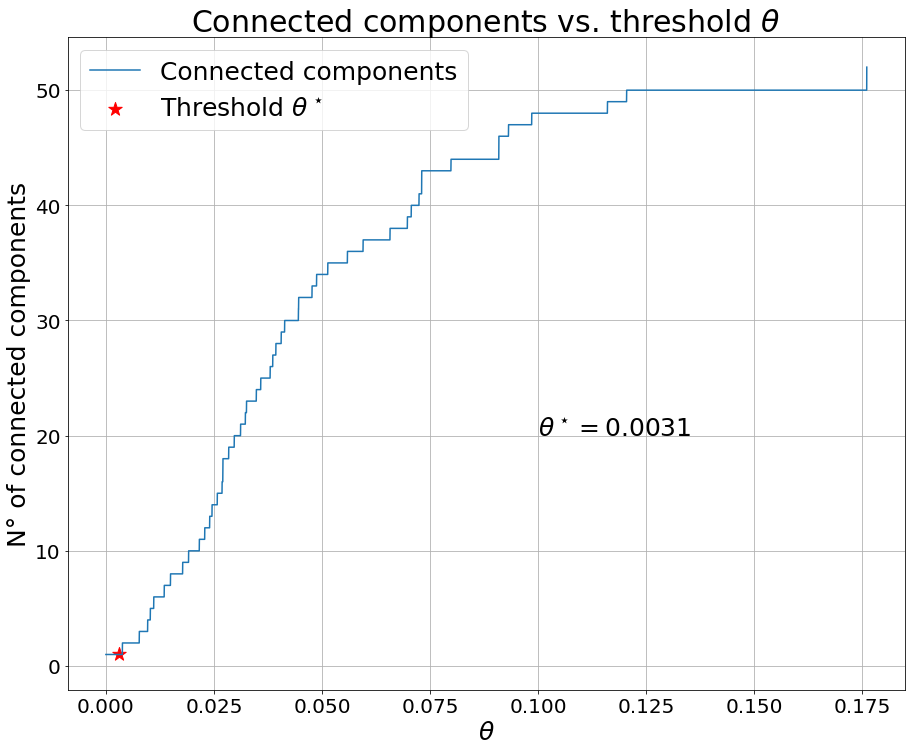

In [30]:
plt.figure(figsize=(15,12))
plt.title(r"Connected components vs. threshold $\theta$", fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel(r"$\theta$", fontsize=25)
plt.ylabel("N° of connected components", fontsize=25)
numbers=np.array([max(count_components(i),1) for i in Matrices])
plt.plot(theta, numbers, label="Connected components")
plt.scatter(theta_star, count_components(Matrices[index])+1, 
            label=r"Threshold $\theta^\star$", color='r', marker='*', s=200)
plt.grid()
plt.text(x=0.1, y=20, s=r"$\theta^\star=$"+'%.4f' % theta_star, fontsize=25)
plt.legend(fontsize=25)
plt.savefig("connected_components.pdf", bbox_inches='tight')
plt.show()

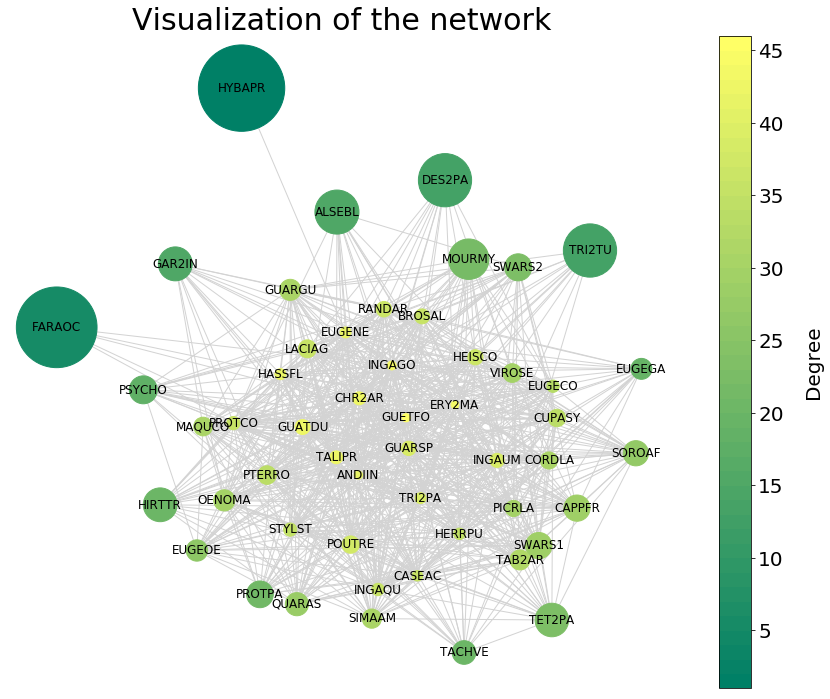

In [31]:
adj = Matrices[index]
names = ab2[0].index[mask].tolist() #contains the species' names
relabelling_dict = {key:name for (key,name) in zip(range(adj.shape[0]), names)}
degrees = np.sum(adj.astype(bool), axis=1).tolist()
numbers = emp_avg[mask].astype(int).tolist()

#############################################################################
# CREATING THE GRAPH OBJECT AND SETTING THE SPECIES' NAMES AS NODES' LABELS #
#############################################################################
Wstar = nx.from_numpy_matrix(adj.astype(bool))
Wstar = nx.relabel_nodes(Wstar, relabelling_dict)
f, axs = plt.subplots(1,1,figsize=(15,12))

plt.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    top=False,
    left=False,
    right=False,
    labelbottom=False,
    labelleft=False)

axs.set_title("Visualization of the network", fontsize=30)
positions = nx.drawing.layout.fruchterman_reingold_layout(Wstar, k=10)
nx.draw_kamada_kawai(Wstar, with_labels=True, font_color='k', node_color=degrees,
                edge_color = '#D3D3D3', node_size=50*emp_avg[mask], cmap='summer', font_size=12)
#
# SETTING THE COLORBAR FOR THE DEGREE
#
cmap = plt.get_cmap(lut = max(degrees)-min(degrees), name='summer')
norm = mpl.colors.Normalize(vmin=min(degrees),vmax=max(degrees))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Degree', fontsize=20, labelpad=20)
cbar.ax.set_yticklabels(labels=[i for i in range(min(degrees),max(degrees)) if i%5==0],fontdict={"fontsize":20})
plt.savefig("network.pdf", bbox_inches='tight')
plt.show()


##########################################
# CALCULATING THE QUANTITIES OF INTEREST #
##########################################
degree_distr = np.array([i for i in nx.degree(Wstar)])[:,1].astype(int)
diameter = nx.diameter(Wstar)
clustering = nx.clustering(Wstar)
degree_assortativity = nx.degree_assortativity_coefficient(Wstar)
betweenness = nx.betweenness_centrality(Wstar)

dictio = {
    "Degree distribution": degree_distr,
    "Diameter": diameter,
    "Clustering coefficients": clustering,
    "Degree assortativity": degree_assortativity,
    "Betweenness centrality": betweenness
         }

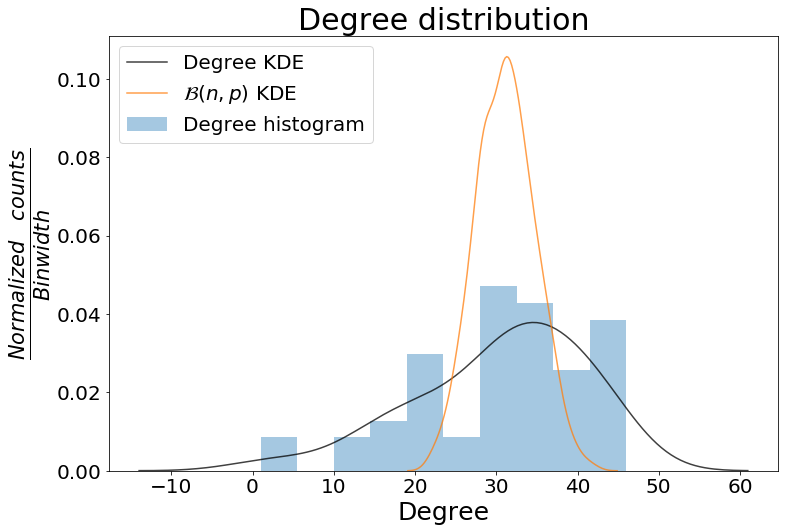

In [32]:
###########################################
# DEGREE DISTRIBUTION: PLOTTING THE HISTO #
###########################################
plt.figure(figsize=(12,8))
plt.title("Degree distribution", fontsize = 30)
plt.ylabel(r"$\frac{Normalized\quadcounts}{Binwidth}$", fontsize=30)
plt.xlabel(r"Degree", fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

bins = 10

sns.distplot(degree_distr, rug=False, kde=True, bins=bins,
             kde_kws={"color": "k", "label": "Degree KDE", "alpha": 0.75},
             hist_kws={"label": "Degree histogram"})

n = adj.shape[0]
p = np.mean(degree_distr)/(n-1)
r = binom.rvs(n, p, size=1000)

sns.distplot(r, rug=False, kde=True, hist=False, bins=bins,
             kde_kws={"label": r"$\mathcal{B}(n,p)$ KDE", "alpha": 0.75},
             hist_kws={"label": "Histogram", "linewidth": 3, "histtype":"step"}) 

plt.legend(fontsize=20)
plt.savefig("degree_distribution.pdf", bbox_inches='tight')
plt.show()

In [33]:
                ###########################
                # DIAMETER, ASSORTATIVITY #
                ###########################
            
a=pd.DataFrame.from_dict({"Diameter": [diameter], "Assortativity": [degree_assortativity]}).T
a.columns=[""]
display(a)
print()


                ############################
                # NODE-SPECIFIC QUANTITIES #
                ############################
            
creation = {
    "Degree": degree_distr,
    "Clustering coefficient": np.array(list(clustering.values())),
    "Betweenness centrality": np.array(list(betweenness.values()))
           }
nodes_info = pd.DataFrame.from_dict(creation).T
nodes_info.columns = [names]
display(nodes_info)

,
Diameter,3.000000
Assortativity,-0.240684


,ALSEBL,ANDIIN,BROSAL,CAPPFR,CASEAC,CHR2AR,CORDLA,CUPASY,DES2PA,ERY2MA,...,STYLST,SWARS1,SWARS2,TAB2AR,TACHVE,TALIPR,TET2PA,TRI2PA,TRI2TU,VIROSE
Degree,15.000000,42.000000,36.000000,29.000000,36.000000,43.000000,31.000000,34.000000,13.000000,44.000000,...,35.000000,29.000000,23.000000,32.000000,20.000000,43.000000,23.000000,39.000000,13.000000,30.000000
Clustering coefficient,0.819048,0.638792,0.671429,0.775862,0.742857,0.635659,0.748387,0.743316,0.833333,0.668076,...,0.747899,0.719212,0.754941,0.774194,0.847368,0.644518,0.778656,0.690958,0.884615,0.662069
Betweenness centrality,0.000611,0.015985,0.010438,0.003455,0.006441,0.017470,0.004951,0.005929,0.000373,0.016446,...,0.006172,0.005073,0.002497,0.004421,0.000952,0.017059,0.002201,0.015113,0.000245,0.007319


### Comparison with Erdős–Rényi model

For a Erdős–Rényi model, some of the quantities above can be expressed as follows:

* degree distribution: the degrees follow a binomial distribution $\mathcal{B}(n,p)$
* clustering coefficient: since it is a random graph, for each node the clustering coefficient is $$C = \frac{c}{n-1} = \frac{\langle k \rangle}{n-1}$$.

The other quantities of interest will be calculated as an average over $Num=100$ realizations of an ER graph.

In [34]:
#creating a set of erdos renyi graphs
Num = 100
n = adj.shape[0]
p = np.mean(degree_distr)/(n-1)

ensemble = [nx.generators.random_graphs.gnp_random_graph(n,p) for i in range(Num)]

ER_deg = np.array([nx.degree(i) for i in ensemble])
ER_deg = np.mean(ER_deg[:,:,1])
ER_deg_sigma = np.std(np.array([nx.degree(i) for i in ensemble]))

ER_ass = np.mean([nx.degree_assortativity_coefficient(i) for i in ensemble])
ER_ass_sigma = np.std([nx.degree_assortativity_coefficient(i) for i in ensemble])

ER_dia = np.mean([nx.diameter(i) for i in ensemble])
ER_dia_sigma = np.std([nx.diameter(i) for i in ensemble])

ER_clust = np.mean([nx.average_clustering(i) for i in ensemble])
ER_clust_sigma = np.std([nx.average_clustering(i) for i in ensemble])

ER_betw = np.mean([max(nx.betweenness_centrality(i).values()) for i in ensemble])
ER_betw_sigma = np.std([max(nx.betweenness_centrality(i).values()) for i in ensemble]) 

In [35]:
Forest = pd.DataFrame(
    {"Diameter": a.T['Diameter'],
    "Assortativity": a.T['Assortativity'],
    "Average Degree": nodes_info.T['Degree'].mean(),
    "Average clustering coefficient": nodes_info.T['Clustering coefficient'].mean(),
    "Max betweenness centrality": nodes_info.T['Betweenness centrality'].max()}
)

compatibilities = [np.abs((ER_dia-a.T['Diameter'])/ER_dia_sigma)[0],
                  np.abs((ER_ass-a.T['Assortativity'])/ER_ass_sigma)[0],
                  np.abs((ER_deg-nodes_info.T['Degree'].mean())/ER_deg_sigma),
                  np.abs((ER_clust-nodes_info.T['Clustering coefficient'].mean())/ER_clust_sigma),
                  np.abs((ER_betw-nodes_info.T['Betweenness centrality'].mean())/ER_betw_sigma)]

Forest = Forest.T.assign(ER_graphs = pd.Series([ER_dia, ER_ass, ER_deg, ER_clust, ER_betw]).values)
Forest = Forest.assign(comps=pd.Series(compatibilities).values)
Forest.columns = ["Forest", "ER graphs", "Compatibilities"]
Forest

,Forest,ER graphs,Compatibilities
Diameter,3.000000,2.000000,inf
Assortativity,-0.240684,-0.039867,9.217953
Average Degree,30.423077,30.421923,0.000103
Average clustering coefficient,0.728693,0.595710,9.743539
Max betweenness centrality,0.053244,0.013159,3.802521


# APPENDIX

#### SADDLE POINT SOLUTION

In this second section, the hamiltonian to be considered is the following:
$$
H(\{\sigma\}) = - \sum_{j=1}^{S} \lambda_j \sigma_j -\frac{k}{S}\left(\sum_{j=1}^{S}\sigma_j\right)^2
$$

The suggested course of action was to perform a mixture of metropolis algorithm and gradient descent in order to get an approximate value of the parameters for such a model.
However, we performed some introductory calculations involving the Hubbard-Stratonovich transformation and the saddle point approximation, as  to have a meaningful initialization of the parameters.
The partition function is 

\begin{align*}
Z = 
&\sum_{\{\sigma\}} \exp (-H(\{\sigma\})) = 
\sum_{\{\sigma\}} \exp  \left[\sum_{j=1}^{S} \lambda_j \sigma_j +\frac{k}{S}\left(\sum_{j=1}^{S}\sigma_j\right)^2\right]\\
\underrightarrow{H.S.} \quad
&=\sum_{\{\sigma\}} \exp  \left[\sum_{j=1}^{S} \lambda_j \sigma_j\right] \int_{-\infty}^{+\infty} \sqrt{\frac{S}{4\pi k}} dx \exp \left[-\frac{Sx^2}{4k}+\left(\sum_{i=1}^{S}\sigma_i\right)x\right]\\
&=\sqrt{\frac{S}{4\pi k}} \int_{-\infty}^{+\infty} dx \exp \left[-\frac{Sx^2}{4k}\right] \prod_{i=1}^{S} \sum_{\sigma_i= \pm 1} \exp\left[\sigma_i \left(x+\lambda_i\right)\right]\\
&=\sqrt{\frac{S}{4\pi k}} \int_{-\infty}^{+\infty} dx \exp \left[-\frac{Sx^2}{4k}\right] \prod_{i=1}^{S} \left[2\cosh(\lambda_i+x)\right]\\
&=\sqrt{\frac{S}{4\pi k}} \int_{-\infty}^{+\infty} dx \exp \left[S\left(-\frac{x^2}{4k} + \frac{1}{S}\sum_{i=1}^{S} \log\left(2\cosh(\lambda_i+x)\right)\right)\right] 
\end{align*}

which can be approximated through saddle point:

\begin{align*}
Z \approx Z^* = \sqrt{\frac{S}{4\pi k}} &\hspace{0.5em} e^{S\mathcal{L}(x_m)}, \quad \quad \mathcal{L}(x)=\left(-\frac{x^2}{4k} + \frac{1}{S}\sum_{i=1}^{S} \log\left(2\cosh(\lambda_i+x)\right)\right)
\end{align*}

where $x_m$ is to be evaluated through the self-consistency equation

\begin{align*}
x_m : \quad \frac{\partial \mathcal{L}(x)}{\partial x} \biggr\rvert_{x=x_m} \hspace{-1em}=0 \quad\rightarrow\quad 
x_m = \frac{2k}{S}\sum_{i=1}^{S} \tanh\left(x_m+\lambda_i\right)
\end{align*}

Then, using the saddle point approximation for $Z$, we can calculate the approximated parameters as before:

\begin{align*}
\frac{\partial \log Z^*}{\partial \lambda_i} = \langle \sigma_i \rangle_{model} \stackrel{!}{=} \langle \sigma_i \rangle_{emp}
\end{align*}
\begin{align*}
\frac{\partial \log Z^*}{\partial k} = \frac{\langle \left(S_+-S_-)^2\right) \rangle_{model}}{S} \stackrel{!}{=}  \frac{ \langle \left(S_+-S_-)^2\right) \rangle_{emp} }{S}
\end{align*}

which yield, respectively,

\begin{align*}
\langle \sigma_i \rangle_{emp} = \tanh(\lambda_i+x_m), \quad \quad i=1,...,S,
\end{align*}

and

\begin{align*}
\frac{\langle \left(S_+-S_-)^2\right) \rangle_{emp}}{S} = -\frac{1}{2k} + \frac{Sx_m^2}{4k^2}
\end{align*}

These, combined with the self-consistency equation for $x_m$, give the following expressions for the parameters:

\begin{align*}
\lambda_i &= \tanh^{-1}\left(\langle\sigma_i\rangle_{emp}\right)-x_m, \quad \quad i=1,...,S,\\
\frac{1}{2k}&=-\frac{1}{S}\left[\Bigg\langle\left(\sum_{i=1}^{S}\sigma_i\right)^2\Bigg\rangle_{emp} - 
\left(\sum_{i=1}^{S}\langle\sigma_i\rangle_{emp}\right)^2\right]=-\frac{\text{Var}(\sum_{i=1}^{S}\sigma_i)_{emp}}{S}
\end{align*}

After inverting the previous formulas, we get the following values:

\begin{align*}
x_m &= \frac{2k}{S}\sum_{i=1}^{S}\langle\sigma_i\rangle_{emp},\\
k&= -\frac{S}{2\text{Var}(\sum_{i=1}^{S}\sigma_i)_{emp}},\\
\lambda_i&=\tanh^{-1}\left(\langle\sigma_i\rangle_{emp}\right)-x_m, \quad\quad i=1,...,S.
\end{align*}


We now test the performance of the gradient descent above on this initialization.

In [36]:
        ###########################
        # SADDLE POINT PARAMETERS #
        ###########################
        
sig_sq = np.mean(np.square(np.sum(2*np.array(ab2, dtype=bool)-1, axis=1)))/S
sigma = np.mean(2*np.array(ab2, dtype=bool)-1, axis=0)        

k_SP = -(S/2)/(np.mean(np.square(np.sum(2*np.array(ab2, dtype=bool)-1, axis=1)))-np.square(np.sum(sigma)))
xm_SP = ((2*k)/S)*(np.sum(sigma))
lambda_SP = np.array([np.arctanh(i) if i<1 else 10 for i in sigma])-xm_SP

param_SP = np.append(lambda_SP, k_SP)

In [37]:
###################################### SGD ######################################

################################
# initialization of the params #
################################

param_SGD_SP = param_SP


####################
# algorithm params #
####################

epochs = 500 #number of adjournments
N = 100 #number of metropolis states over which we calculate the average
sims = 1e4 #number of steps in metropolis algorithms
learn_rate = 0.005


##########################
# calculating the params #
##########################

param_history_SGD_SP = [param_SGD_SP]
for i in range(epochs):
    param_SGD_SP = adjourn(param_SGD_SP, sigma, sig_sq, metropolis(param_SGD_SP, sims, N), learn_rate=learn_rate)
    param_history_SGD_SP.append(param_SGD_SP)
    
#the resulting parameters are computed as the mean of their values over the last "his" iterations
his = 100 #the amount of iterations over which to average
param_SGD_SP = np.mean(param_history_SGD_SP[epochs-his:], axis=0)    

In [38]:
###################################### ADAM SP ######################################

param_ADAM_SP = param_SP


####################
# algorithm params #
####################

epochs = 500  #number of adjournments
N = 200       #number of metropolis states over which we calculate the average
sims = 1e4    #number of steps in metropolis algorithms
learn_rate = 0.005


##########################
# calculating the params #
##########################

param_history_ADAM_SP = [param_ADAM_SP]
m,s = np.zeros(S+1),np.zeros(S+1) #initializing the moments parameters
for i in range(epochs):
    param_ADAM_SP, m, s = ADAM(param_ADAM_SP, m, s, metropolis(param_ADAM_SP, sims, N), i+1, l_rate=learn_rate)
    param_history_ADAM_SP.append(param_ADAM_SP)

#the resulting parameters are computed as the mean of their values over the last "his" iterations
his = 100 #the amount of iterations over which to average
param_ADAM_SP = np.mean(param_history_ADAM_SP[epochs-his:], axis=0)    

We now proceed to check if the various parameters lead to metropolis-simulated magnetization mirroring the empirical values.

In [39]:
        #####################################################
        # DRAWING MAGNETIZATIONS FROM EACH PARAMETER FAMILY #
        #####################################################

N = 10 #number of "final" states for each metropolis simulation.
sims = 10000 #number of metropolis simulations.
avg = 200 #number of metropolis simulations; set to 200 as to mimic the empirical average.

SGD_magnetization = np.mean([np.mean(metropolis(param, sims, N), axis=0) for i in range(avg)], axis=0)
ADAM_magnetization = np.mean([np.mean(metropolis(param_ADAM, sims, N), axis=0) for i in range(avg)], axis=0)
ADAM_SP_magnetization = np.mean([np.mean(metropolis(param_ADAM_SP, sims, N), axis=0) for i in range(avg)], axis=0)
SGD_SP_magnetization = np.mean([np.mean(metropolis(param_SGD_SP, sims, N), axis=0) for i in range(avg)], axis=0)
SP_magnetization = np.mean([np.mean(metropolis(param_SP, sims, N), axis=0) for i in range(avg)], axis=0)

#in order to aid visualization, the parameters are sorted on the basis of the empirical ones.

indexing = np.argsort(sigma) #keeps track of the ordering of the emprical parameters
emp_magnetization = np.sort(sigma) #sorted empirical parameters

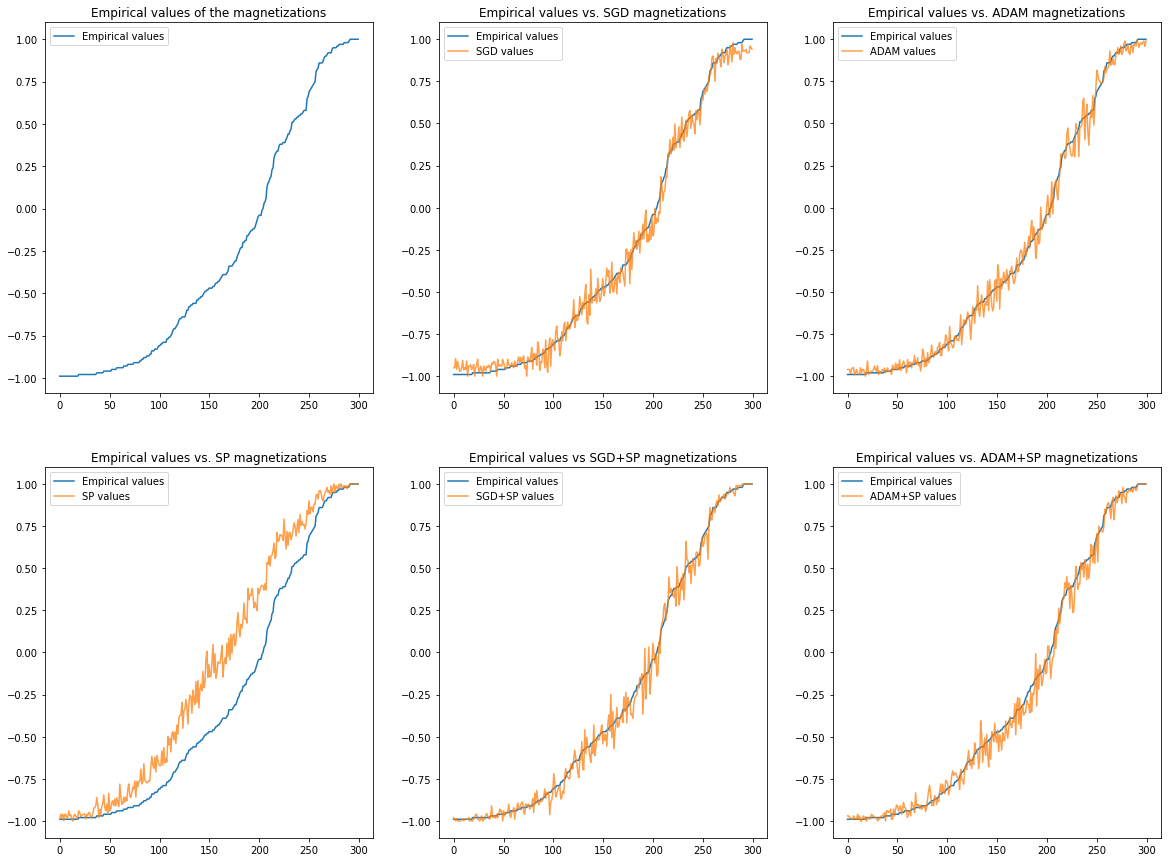

In [40]:
        ######################################################
        # VISUALIZATIONS OF THE DIFFERENT PARAMETER FAMILIES #
        ######################################################


xs=np.linspace(0,S,S) 

gridsize = (2,3)
figure = plt.figure(figsize=(20,15))
ax1 = plt.subplot2grid(gridsize, (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid(gridsize, (0,1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid(gridsize, (0,2), rowspan=1, colspan=1)
ax4 = plt.subplot2grid(gridsize, (1,0), rowspan=1, colspan=1)
ax5 = plt.subplot2grid(gridsize, (1,1), rowspan=1, colspan=1)
ax6 = plt.subplot2grid(gridsize, (1,2), rowspan=1, colspan=1)

ax1.set_title("Empirical values of the magnetizations")
ax1.plot(xs, emp_magnetization, label="Empirical values")
ax1.legend()

ax2.set_title("Empirical values vs. SGD magnetizations")
ax2.plot(xs, emp_magnetization, label="Empirical values")
ax2.plot(xs, SGD_magnetization[indexing], label="SGD values", alpha=0.75)
ax2.legend()

ax3.set_title("Empirical values vs. ADAM magnetizations")
ax3.plot(xs, emp_magnetization, label="Empirical values")
ax3.plot(xs, ADAM_magnetization[indexing], label="ADAM values", alpha=0.75)
ax3.legend()

ax4.set_title("Empirical values vs. SP magnetizations")
ax4.plot(xs, emp_magnetization, label="Empirical values")
ax4.plot(xs, SP_magnetization[indexing], label="SP values", alpha=0.75)
ax4.legend()

ax5.set_title("Empirical values vs SGD+SP magnetizations")
ax5.plot(xs, emp_magnetization, label="Empirical values")
ax5.plot(xs, SGD_SP_magnetization[indexing], label="SGD+SP values", alpha=0.75)
ax5.legend()

ax6.set_title("Empirical values vs. ADAM+SP magnetizations")
ax6.plot(xs, emp_magnetization, label="Empirical values")
ax6.plot(xs, ADAM_SP_magnetization[indexing], label="ADAM+SP values", alpha=0.75)
ax6.legend()

plt.savefig("emp_vs_sim_magnetizations.pdf", bbox_inches='tight')
plt.show()

It seems that the best results in terms of mirroring the real magnetizations are achieved by a mixture of SP approximation and gradient descent from there. We now check the compatibilities of these $\lambda$ with 0, as was previously done for the SGD/ADAM values above.

In [41]:
compSP = np.mean(param_SP[:-1])/np.std(param_SP[:-1]) 
print(r"The SP compatibility of the lambdas with 0 is:", compSP)

compADAMSP = np.mean(param_ADAM_SP[:-1])/np.std(param_ADAM_SP[:-1])
print(r"The ADAM+SP compatibility of the lambdas with 0 is:", compADAMSP)

compSGDSP = np.mean(param_SGD_SP[:-1])/np.std(param_SGD_SP[:-1]) 
print(r"The SGD+SP compatibility of the lambdas with 0 is:", compSGDSP)

The SP compatibility of the lambdas with 0 is: 0.04916759085389843
The ADAM+SP compatibility of the lambdas with 0 is: -0.00671364816836174
The SGD+SP compatibility of the lambdas with 0 is: 0.045547147538516915


However, the model at hand is not an RFIM: the fields are not gaussian distibuted; care must be taken when dealing with the saddle point solution.